<div class="alert alert-block alert-success">
Problem Statement:

The goal is the retention of good cab drivers as it is a crucial business driver. A sound RL-based system for assisting cab drivers isneeded as it can potentially retain and attract new cab drivers
</div>

<div class="alert alert-block alert-warning">
Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field. It is important that drivers choose the ' right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day.
</div>

<div class="alert alert-block alert-info"> Rules:
If the cab is already in use, then the driver won't get any requests. Otherwise, he may get multiple request(s). He can either decide to take any one of these requests or can go offline, i.e., not accept any request at all.
</div>

#### We will create a Cab-Driver Agent that will help us achieve the goal

### Cab-Driver Agent

#### Step1: Importing Libraries

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Checking some values of the time matrix

In [3]:
print(Time_matrix[1][2])

[[ 5.  6.  5.  7.  7.  9.  7.]
 [ 5.  6.  5.  7.  7.  9.  7.]
 [ 5.  6.  5.  7.  7.  9.  7.]
 [ 5.  6.  5.  7.  7.  9.  7.]
 [ 5.  6.  5.  7.  7.  9.  7.]
 [ 5.  6.  5.  7.  7.  9.  7.]
 [10.  9.  4. 10.  7. 11.  4.]
 [10.  9.  4. 10.  7. 11.  4.]
 [10.  9.  4. 10.  7. 11.  4.]
 [10.  9.  4. 10.  7. 11.  4.]
 [10.  9.  4. 10.  7. 11.  4.]
 [10.  9.  4. 10.  7. 11.  4.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 1.  3.  1.  1.  1.  2.  2.]
 [ 5. 11.  7.  8. 10.  6.  8.]
 [ 5. 11.  7.  8. 10.  6.  8.]
 [ 5. 11.  7.  8. 10.  6.  8.]
 [ 5. 11.  7.  8. 10.  6.  8.]
 [ 5. 11.  7.  8. 10.  6.  8.]
 [ 5. 11.  7.  8. 10.  6.  8.]]


#### Tracking the state-action pairs for checking convergence


In [4]:
### Defining collection of state-action pairs
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [5]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_vals = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))]    
    for q_values in sample_q_vals:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

#### Checking states tracked

In [6]:
States_track

defaultdict(dict, {})

#### Creating a function that can store pickle file with Highest Protocol

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

#### Defining DQNAgent claass

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001       
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.001
        self.epsilon_min = 0.0001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size number of actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))       
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, action_space, poss_actions_index):
    # Write your code here:    
    #    poss_actions_index, actions = env.requests(state)
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            index_len = random.randrange(len(poss_actions_index))
            action_index = poss_actions_index[index_len]
            action = action_space[action_index]
            return action_index, action
        else:
            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            action_index_argmax = np.argmax(q_value[0])
            action_argmax = action_space[action_index_argmax]
            return action_index_argmax, action_argmax
        
   
    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory        
        self.memory.append((state, action, reward, next_state))
   
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
            #    terminals.append(terminal)
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)
        
    def store_q_values(self):
        """" We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])

    def get_model_weights(self):
        return self.model.get_weights()

#### Defining the no of episodes to run

In [9]:
Episodes = 5001

### DQN block

In [10]:
### Defining the start time
start_time = time.time()
#Initializing the values of rewards,episodes and average rewards per episode
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

# Instantiating the CabDriver class
env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(
    env.state_init)))

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        poss_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, poss_actions_index)
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action,
                                                                             Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index,
                            reward, env.state_encod_arch1(next_state))
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        
       
        if t >= 24 * 30:
            #print("state terminated")
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, score, len(agent.memory), agent.epsilon))
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        
        save_obj(agent.get_model_weights(), "Taxi_DQN_" + str(score))
        
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)

    

episode 0, reward -153.0, memory_length 158, epsilon 1.0
Total time taken  9.188220977783203
episode 1, reward -546.0, memory_length 311, epsilon 0.9990005997833917
episode 2, reward -80.0, memory_length 457, epsilon 0.9980021984674663
episode 3, reward -318.0, memory_length 598, epsilon 0.9970047950538227
episode 4, reward -149.0, memory_length 743, epsilon 0.9960083885450571
episode 5, reward -221.0, memory_length 887, epsilon 0.9950129779447631
episode 6, reward -72.0, memory_length 1033, epsilon 0.9940185622575299
episode 7, reward -266.0, memory_length 1172, epsilon 0.9930251404889417
episode 8, reward -188.0, memory_length 1327, epsilon 0.9920327116455769
episode 9, reward 137.0, memory_length 1480, epsilon 0.9910412747350064
episode 10, reward -321.0, memory_length 1639, epsilon 0.9900508287657932
episode 11, reward -453.0, memory_length 1783, epsilon 0.9890613727474912
episode 12, reward 4.0, memory_length 1922, epsilon 0.9880729056906443
episode 13, reward -90.0, memory_length

In [11]:
#### Tracking the total time taken to run all episodes
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  46656.108028411865


### Tracking Convergence

#### Plotting the graph of rewards per episode with the length of rewards per epsiode

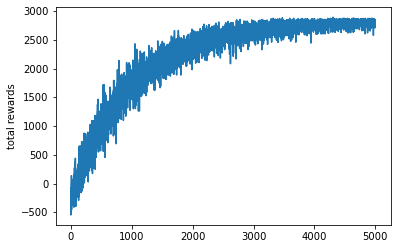

In [12]:
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

#### There is an increasing trend from the first few episodes to the end of episodes

#### Let's see how the values of average reward per episodes are 

In [13]:
# Average reward per 50 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 50:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-180.48, -4.46, 124.42, 249.82, 431.62, 510.78, 661.82, 744.42, 929.9, 970.16, 1049.38, 1150.62, 1175.66, 1266.4, 1384.28, 1478.1, 1525.26, 1574.86, 1672.66, 1739.84, 1749.68, 1809.52, 1843.9, 1930.86, 1903.06, 1963.0, 2028.32, 2036.98, 2074.6, 2099.94, 2140.54, 2176.08, 2199.44, 2197.94, 2267.18, 2285.7, 2302.98, 2305.02, 2361.28, 2361.98, 2407.26, 2384.3, 2459.12, 2483.86, 2471.0, 2490.1, 2521.0, 2529.18, 2521.76, 2543.62, 2567.72, 2593.84, 2592.26, 2593.22, 2575.2, 2628.54, 2625.14, 2656.6, 2646.78, 2665.16, 2679.64, 2651.66, 2665.9, 2693.18, 2691.34, 2700.94, 2718.7, 2712.46, 2719.36, 2727.28, 2713.64, 2742.54, 2723.12, 2758.16, 2748.78, 2746.04, 2767.04, 2756.26, 2737.68, 2781.18, 2762.14, 2779.52, 2782.14, 2789.6, 2784.46, 2795.72, 2782.44, 2793.98, 2783.58, 2799.5, 2795.92, 2779.02, 2808.5, 2811.5, 2805.72, 2811.82, 2808.04, 2813.94, 2807.82, 2807.76, 2833.0]


#### Let's check how the Q-values are acting for a particular state and action

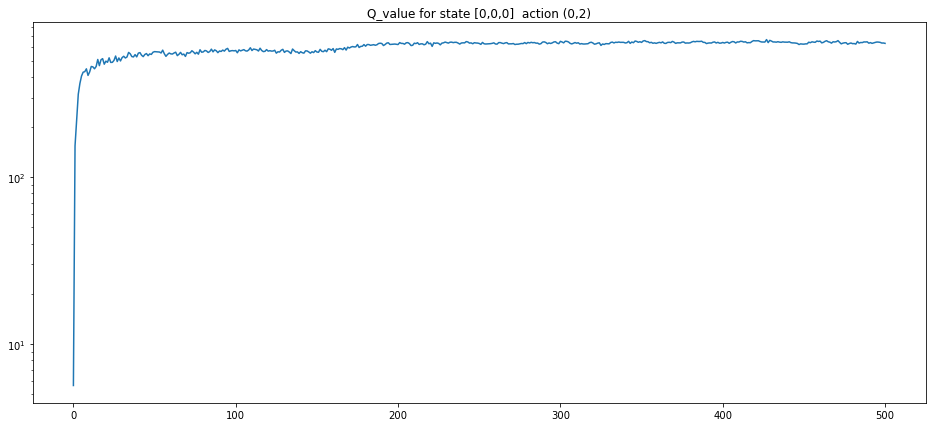

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

#### Let's check the convergence through the epsilon decay

In [15]:
time = np.arange(0,5000)
epsilon = []
for i in range(0,5000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.001*i))

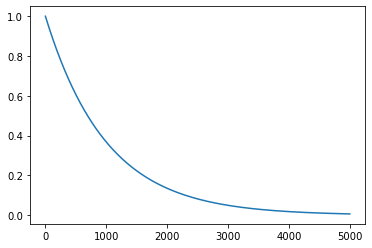

In [16]:
plt.plot(time, epsilon)
plt.show()

#### We can see that the graph is converging in a good way for 5000 episodes